In [55]:
# Import all packages needed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import json
from pathlib import Path
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [56]:
# Import style.json
style_path: Path = Path.cwd().parent / 'style' / 'style.json'
with open(style_path, 'r') as f: # opens the style.json file
    style: dict = json.load(f) # loads as a dictionary object

In [57]:
# Loading Data (data file must be in the same directory as jupyter notebook)
# Import data from excel file
# TODO: replace filename with the name of your data file
raw_data_filename: str = "../data/004/004-M_PBTS_DPDS_MK.csv"

# Tell program to read the data
raw_data: pd.DataFrame = pd.read_csv(raw_data_filename) # read data into a pandas dataframe

# Output data
raw_data

,0.01M_PBTS,Unnamed: 1,0.01M_DPDS,Unnamed: 3,0.01M_MK,Unnamed: 5,0.001M_PBTS,Unnamed: 7,0.001M_DPDS,Unnamed: 9,0.001M_MK,Unnamed: 11,0.0001M_PBTS,Unnamed: 13,0.0001M_DPDS,Unnamed: 15,0.0001M_MK,Unnamed: 17
0,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs
1,800,0.000944414,800,0.000989011,800,0.001776091,800,0.002297258,800,0.001702098,800,0.001683439,800,0.001336268,800,0.000140402,800,0.000738663
2,799,0.000909861,799,0.000928175,799,0.001832835,799,0.002288566,799,0.001639888,799,0.001622661,799,0.001337722,799,0.000122018,799,0.000705836
3,798,0.000894867,798,0.000933934,798,0.001818798,798,0.002342177,798,0.001611488,798,0.001649554,798,0.001363793,798,3.84E-05,798,0.000791252
4,797,0.000949888,797,0.000932922,797,0.001837956,797,0.002223644,797,0.001561943,797,0.001595068,797,0.001307058,797,8.32E-05,797,0.000647736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,End Method Modifications,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
963,<Current Wavelength>,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
964,<SBW (nm)>,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
965,<Energy>,43.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# Data preprocessing specific to UV-Vis
# NOTE: for those doing degradation studies, you may want to normalize the data by the maximum absorbance value in those runs
def preprocess(data: pd.DataFrame, normalize: bool = False, normalize_by_max_abs: bool = False, baseline: bool = False, normalize_by_conc: bool = False):
    """Function that applies transformation to the dataframe which will make it ready for plotting. Note, this is specific to UV-Vis.
    """
    # Drop row with index = 0
    data = data.drop(labels=0, axis=0) # drop row with index = 0

    # Drop additional information
    indexes = data[data.columns[0]].str.find("Collection Time:") # find the index of the row with the string "Collection Time:"
    first_occurrence: int = indexes[indexes==0.0].index[0] # find the index of the first occurrence of the string "Collection Time:"
    data = data.drop(labels=range(first_occurrence-3, len(data.index)+1), axis=0) # drop the rows with the additional information

    # Rename column names (y-data)
    column_rename: dict = {}
    for i in range(1, len(data.columns), 2): # loop through every other column
        column_rename[data.columns[i]] = data.columns[i-1] + "_Abs" # rename every other column by adding _Abs
    data = data.rename(columns=column_rename) # rename the columns

    # Rename column name (x-data)
    data = data.rename(columns={data.columns[0]: "Wavelength (nm)"}) # rename the first column to "Wavelength (nm)"
    # Convert columns to numeric
    data = data.apply(pd.to_numeric)
    # Baseline correction
    if baseline: # if baseline is True, execute the code below
        for col in data.columns:
            if "Abs" in col:
                print(data[col][0:50])
                data[col] = data[col] - np.average(data[col][0:50]) # subtract the average of the first 50 data points from every absorbance value

    # Normalize absorbance values
    if normalize and normalize_by_max_abs:
        raise ValueError("You cannot normalize and also normalize by max absorbance. Please set only one of them to True.")
    elif normalize: # if normalize is True, execute the code below
        for col in data.columns:
            if "Abs" in col:
                max_val: float = data[col].max() # find the maximum absorbance value
                data[col] = data[col] / max_val # divide every absorbance value by the maximum absorbance value
    elif normalize_by_max_abs:
        max_val: float = 0
        for col in data.columns:
            if "Abs" in col:
                if data[col].max() > max_val:
                    max_val = data[col].max()
        for col in data.columns:
            if "Abs" in col:
                data[col] = data[col] / max_val

    # Normalize by concentration (plot molar extinction coefficient)
    if normalize_by_conc:
        for i in range(1, len(data.columns), 2):
            col = data.columns[i]
            if "Abs" in col:
                print(col)
                data[col] = data[col] / float(col.split("M_")[0])
    
    return data

# TODO: choose the replicates you want to be averaged
def average_replicates(data: pd.DataFrame, columns_to_avg: list):
    """Function that averages the replicates of the data.
    """
    # Average replicates
    for column in columns_to_avg:
        # gather all columns with the same name
        columns: list = [col for col in data.columns if column in col]
        # average the columns and add new column to dataframe
        avg_column_name: str = column + "_avg_n=" + str(len(columns))
        data[avg_column_name] = data[columns].mean(axis=0)
        # drop the columns that were averaged
        data = data.drop(labels=columns, axis=1)
    
    # find the indexes of the averaged columns
    indexes: list = [i for i in range(len(data.columns)) if "avg" in data.columns[i]]
    # keep only the first column and the averaged columns
    data = data.iloc[:, [0] + indexes]
    return data

raw_data

,0.01M_PBTS,Unnamed: 1,0.01M_DPDS,Unnamed: 3,0.01M_MK,Unnamed: 5,0.001M_PBTS,Unnamed: 7,0.001M_DPDS,Unnamed: 9,0.001M_MK,Unnamed: 11,0.0001M_PBTS,Unnamed: 13,0.0001M_DPDS,Unnamed: 15,0.0001M_MK,Unnamed: 17
0,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs
1,800,0.000944414,800,0.000989011,800,0.001776091,800,0.002297258,800,0.001702098,800,0.001683439,800,0.001336268,800,0.000140402,800,0.000738663
2,799,0.000909861,799,0.000928175,799,0.001832835,799,0.002288566,799,0.001639888,799,0.001622661,799,0.001337722,799,0.000122018,799,0.000705836
3,798,0.000894867,798,0.000933934,798,0.001818798,798,0.002342177,798,0.001611488,798,0.001649554,798,0.001363793,798,3.84E-05,798,0.000791252
4,797,0.000949888,797,0.000932922,797,0.001837956,797,0.002223644,797,0.001561943,797,0.001595068,797,0.001307058,797,8.32E-05,797,0.000647736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,End Method Modifications,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
963,<Current Wavelength>,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
964,<SBW (nm)>,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
965,<Energy>,43.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# NOTE: change True to False if you don't want normalization or baseline correction
preprocessed_data: pd.DataFrame = preprocess(raw_data, normalize=False, normalize_by_max_abs=False, baseline=False, normalize_by_conc=True)
preprocessed_data

0.01M_PBTS_Abs
0.01M_DPDS_Abs
0.01M_MK_Abs
0.001M_PBTS_Abs
0.001M_DPDS_Abs
0.001M_MK_Abs
0.0001M_PBTS_Abs
0.0001M_DPDS_Abs
0.0001M_MK_Abs


,Wavelength (nm),0.01M_PBTS_Abs,0.01M_DPDS,0.01M_DPDS_Abs,0.01M_MK,0.01M_MK_Abs,0.001M_PBTS,0.001M_PBTS_Abs,0.001M_DPDS,0.001M_DPDS_Abs,0.001M_MK,0.001M_MK_Abs,0.0001M_PBTS,0.0001M_PBTS_Abs,0.0001M_DPDS,0.0001M_DPDS_Abs,0.0001M_MK,0.0001M_MK_Abs
1,800.0,0.094441,800.0,0.098901,800.0,0.177609,800.0,2.297258,800.0,1.702098,800.0,1.683439,800.0,13.36268,800.0,1.40402,800.0,7.38663
2,799.0,0.090986,799.0,0.092817,799.0,0.183284,799.0,2.288566,799.0,1.639888,799.0,1.622661,799.0,13.37722,799.0,1.22018,799.0,7.05836
3,798.0,0.089487,798.0,0.093393,798.0,0.181880,798.0,2.342177,798.0,1.611488,798.0,1.649554,798.0,13.63793,798.0,0.38400,798.0,7.91252
4,797.0,0.094989,797.0,0.093292,797.0,0.183796,797.0,2.223644,797.0,1.561943,797.0,1.595068,797.0,13.07058,797.0,0.83200,797.0,6.47736
5,796.0,0.093502,796.0,0.094610,796.0,0.193413,796.0,2.331818,796.0,1.627728,796.0,1.770710,796.0,13.54393,796.0,1.11868,796.0,8.55804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,203.0,570.411444,203.0,543.520451,203.0,483.424711,203.0,4898.837566,203.0,5323.174477,203.0,4764.680862,203.0,4609.88611,203.0,8461.13145,203.0,7081.63738
599,202.0,608.611822,202.0,539.390612,202.0,486.439896,202.0,5151.761532,202.0,5503.455162,202.0,4748.438835,202.0,5006.37412,202.0,8810.51540,202.0,7138.09788
600,201.0,574.269009,201.0,559.974718,201.0,487.911606,201.0,5266.271114,201.0,5460.726738,201.0,4756.015301,201.0,5426.70250,201.0,9097.72813,201.0,7128.28994
601,200.0,563.634109,200.0,545.864773,200.0,490.502405,200.0,5821.673870,200.0,5370.318413,200.0,4747.647285,200.0,5850.46113,200.0,9307.45840,200.0,7067.89613


In [60]:
# NOTE: User must change the sample names to the correct column names. 
# NOTE: Please specify the replicate number if applicable.
sample_name_to_plot: list[str] = [
    "0.0001M_PBTS",
    "0.0001M_DPDS",
    "0.0001M_MK",
]
# correct names with Abs
sample_name_to_plot = [name + "_Abs" for name in sample_name_to_plot]

# Average replicates by experiment label name
# averaged_data: pd.DataFrame = average_replicates(preprocessed_data, sample_name_to_plot)
# averaged_data

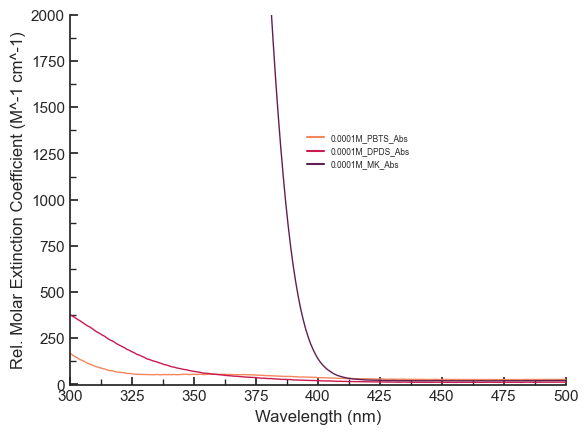

In [63]:
# If you want to rename, uncomment and insert here!
# sample_name_rename: dict = {"2023_06_22_C10-dialdehyde-chcl3_Abs": "RENAME", "2023_06_22_benzene-diphosphonate1_Abs": "RENAME", "2023_06_22_fluorene-diphosphonate_Abs": "RENAME", "2023_06_22_model-compound_Abs" : "RENAME", "2023_06_22_AU-038-A2-3_Abs" : "RENAME"}
# preprocessed_data = preprocessed_data.rename(columns=sample_name_rename)
# Convert to "tidy" form
# Plot the data!
plot_data: pd.DataFrame = pd.melt(
    preprocessed_data,
    id_vars=["Wavelength (nm)"],
    value_vars=sample_name_to_plot,
    var_name="sample",
    value_name="Rel. Molar Extinction Coefficient (M^-1 cm^-1)",
)
# Set correct dtypes
plot_data = plot_data.astype(
    {"Wavelength (nm)": "float32", "sample": "str", "Rel. Molar Extinction Coefficient (M^-1 cm^-1)": "float32"}
)
# seaborn styles
sns.set_style("ticks")
sns.set_context("notebook") # gives the blank white background theme
# sns.set_theme(context="notebook", style="white", font="Helvetica")

graph = sns.lineplot(
    data=plot_data, # refers to dataframe that contains the data
    x="Wavelength (nm)", # refers to column header to get all the X data
    y="Rel. Molar Extinction Coefficient (M^-1 cm^-1)", # refers to column header to get all the Y data
    hue="sample",
    palette="rocket_r",  #NOTE: User can change the palette here
    linewidth=style["graph"]["default"]["line_thickness"], # refers to the thickness of the line in the graph (this is set in the style.json file)
)
sns.despine() # this removes the top and right spines of the graph

graph.legend(
    fontsize=style["legend"]["font_size"], # refers to the font size of the legend (this is set in the style.json file)
    bbox_to_anchor=(0.7, 0.7), # refers to the position of the legend anchored in the figure
    title_fontsize=style["legend"]["title_font_size"], # refers to the font size of the legend title
    shadow=False, # refers to whether the legend has a shadow or not
    frameon=False, # refers to whether the legend has a frame or not
)
# font family
plt.rcParams['font.family'] = style["graph"]["default"]["font_family"] # refers to the font family of the text in the graph (this is set in the style.json file)

# y-axis and x-axis ticks
graph.xaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in X-axis
graph.yaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in Y-axis
graph.tick_params(axis="y", direction="in") # direction of major ticks in Y-axis
graph.tick_params(axis="x", direction="in") # direction of major ticks in X-axis
graph.tick_params(axis="y", which="minor", length=4, direction="in") # direction and length of minor ticks in Y-axis
graph.tick_params(axis="x", which="minor", length=4, direction="in") # direction and length of minor ticks in X-axis

# NOTE: User can change the x and y limits here
plt.xlim(300, 500)
# NOTE: User can change the y limits here
plt.ylim(-0.1, 2000)

# NOTE: make sure you comment this out if you want to save your figure in the directory. Otherwise, your figure will look like a blank screen
# plt.show()

# Save the figure
# NOTE: User can change the filename
plt.savefig("UV-Vis.svg", dpi=300, bbox_inches="tight")
plt.savefig("UV-Vis.jpg", dpi=300, bbox_inches="tight")